# Comparison of Different Interpolation Methods and Their Running Times
In this notebook, we compare the performance of different interpolation methods on the same example curve. We also compare the running times of the different methods by running it on 1000 different (synthetic) curves.

To run this comparison, you will need to install the `rpy2` package, which allows us to use the `splinefun` method from R. You can install it using `pip install rpy2`. You will also need to have R installed and be set properly in the current environment on your machine.

Due to the complexity of dependencies, we will not include the installation of R in this notebook. If you are interested in using the `splinefun` method, you can refer to the [rpy2 official documentation](https://rpy2.github.io/doc/latest/html/introduction.html) for installation instructions.



In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

## Make one toy example for Visual Comparison

In [3]:
times_coordinate = np.array([0, 5, 8, 10, 25, 30, 50])
survival_curve = np.array([1, 0.9, 0.88, 0.85, 0.7, 0.6, 0.4])

Fitting different interpolation curves

In [4]:
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
import rpy2.robjects as robjects

linear = interp1d(times_coordinate, survival_curve)
cs = CubicSpline(times_coordinate, survival_curve)
pchip = PchipInterpolator(times_coordinate, survival_curve)
x = robjects.FloatVector(times_coordinate)
y = robjects.FloatVector(survival_curve)
r_splinefun = robjects.r['splinefun']  # extract splinefun method from R
spline_hyman = r_splinefun(x, y, method='hyman')

Plot the interpolated curves. We can see that the linear interpolation is not smooth, while the cubic spline is not monotonic (violating the important property of survival curve) and pchip, hyman are smooth and monotonic. The hyman and cubic are basically identical, except in the last bin.

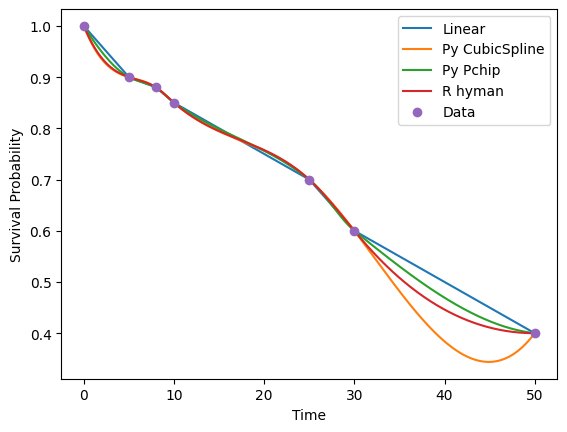

In [5]:
times = np.linspace(0, 50, 1000)
plt.plot(times, linear(times), label='Linear')
plt.plot(times, cs(times), label='Py CubicSpline')
plt.plot(times, pchip(times), label='Py Pchip')
plt.plot(times, spline_hyman(robjects.FloatVector(times)), label='R hyman')
plt.plot(times_coordinate, survival_curve, 'o', label='Data')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Compare Running Times
First we would like to randomly generate 1000 curves to compare the running times of the different methods.

In [6]:
times_coordinate = np.array([0, 1, 5, 8, 10, 15, 25, 30, 50, 70, 100])
times = np.linspace(0, 100, 1000)
# randomize the survival curves
pdf_pre = np.random.rand(len(times_coordinate), 1000)
pdf = pdf_pre / pdf_pre.sum(axis=0)
cdf = pdf.cumsum(axis=0)
cdf = np.insert(cdf, 0, 0, axis=0)
survival_curve = (1 - cdf).clip(min=0, max=1)
survival_curve = survival_curve[:-1, ].T

In [7]:
print(survival_curve[:5])

[[1.         0.99000991 0.98383243 0.84575129 0.64087232 0.47315719
  0.35469346 0.27314956 0.23574757 0.16644224 0.0543155 ]
 [1.         0.90284451 0.81048243 0.79159778 0.66069779 0.54011476
  0.50119073 0.44214459 0.38681926 0.24828344 0.14190133]
 [1.         0.97450667 0.94388436 0.83456417 0.72816452 0.64222135
  0.47553668 0.45513829 0.34488453 0.23495475 0.15865596]
 [1.         0.82158957 0.70475668 0.64573626 0.4841139  0.45353438
  0.41664692 0.29850521 0.26742307 0.14408521 0.01453842]
 [1.         0.89953754 0.8190252  0.76150169 0.72150274 0.66017807
  0.64202433 0.46249787 0.28885175 0.2523546  0.12187288]]


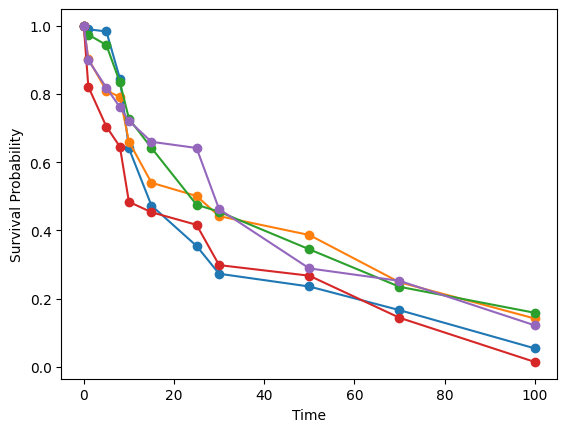

In [8]:
plt.plot(times_coordinate, survival_curve[0, :], 'o-')
plt.plot(times_coordinate, survival_curve[1, :], 'o-')
plt.plot(times_coordinate, survival_curve[2, :], 'o-')
plt.plot(times_coordinate, survival_curve[3, :], 'o-')
plt.plot(times_coordinate, survival_curve[4, :], 'o-')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

Measuring the time using certain function

In [9]:
from Evaluations.util import predict_mean_survival_time, predict_median_survival_time, predict_prob_from_curve

predict_time_method = "Median"
target_time = 20
if predict_time_method == "Median":
    predict_method = predict_median_survival_time
elif predict_time_method == "Mean":
    predict_method = predict_mean_survival_time

def predict_time(predicted_curve, time_coordinates, interpolation):
    predicted_times = []
    for i in range(predicted_curve.shape[0]):
        predicted_time = predict_method(predicted_curve[i, :], time_coordinates, interpolation)
        predicted_times.append(predicted_time)
    predicted_times = np.array(predicted_times)
    return predicted_times

def predict_prob(predicted_curve, time_coordinates, interpolation):
    predict_probs = []
    for i in range(predicted_curve.shape[0]):
        predict_prob = predict_prob_from_curve(predicted_curve[i, :], time_coordinates,
                                               target_time, interpolation)
        predict_probs.append(predict_prob)
    predict_probs = np.array(predict_probs)
    return predict_probs

Choose the function to run, predict_time or predict_prob

In [10]:
function = predict_prob

In [11]:
import datetime

start_time = datetime.datetime.now()
predicted_times_linear = function(survival_curve, times_coordinate, 'Linear')
end_time = datetime.datetime.now()
linear_time = end_time - start_time
print("Linear: ", linear_time)

start_time = datetime.datetime.now()
predicted_times_pchip = function(survival_curve, times_coordinate, 'Pchip')
end_time = datetime.datetime.now()
pchip_time = end_time - start_time
print("Pchip: ", pchip_time)

start_time = datetime.datetime.now()
predicted_times_hyman = function(survival_curve, times_coordinate, 'Hyman')
end_time = datetime.datetime.now()
hyman_time = end_time - start_time
print("Hyman: ", hyman_time)

Linear:  0:00:00.092402
Pchip:  0:00:00.141584
Hyman:  0:00:00.398595


Plot the running times for visual comparison

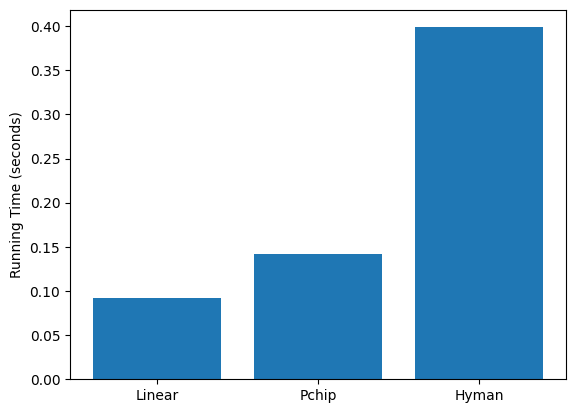

In [12]:
plt.bar(['Linear', 'Pchip', 'Hyman'], [linear_time.total_seconds(), pchip_time.total_seconds(), hyman_time.total_seconds()])
plt.ylabel('Running Time (seconds)')
plt.show()